# Setup

In [1]:
from PIL import Image

In [3]:
import os
import cv2
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from glob import glob
from PIL import Image

# Configuration
DATA_DIR = "Dataset\\train_images"   # Folder where your class subfolders are
IMG_SIZE = 256         # Paper scales images to 256px [cite: 87]

# Check if GPU is available (optional, speeds things up)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Running on: cuda


# Pre-processing

In [4]:
def preprocess_leaf(img_path, show_steps=False):
    # 1. Load Image
    img = cv2.imread(img_path)
    if img is None: return None, None
    
    # Resize (Longer edge -> 256) [cite: 87]
    h, w = img.shape[:2]
    scale = IMG_SIZE / max(h, w)
    img = cv2.resize(img, (int(w * scale), int(h * scale)))
    
    # 2. Background Elimination (K-Means in LAB) [cite: 81-88]
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    pixels = img_lab.reshape((-1, 3))
    
    kmeans = KMeans(n_clusters=2, n_init=3, random_state=42)
    labels = kmeans.fit_predict(pixels)
    
    # Identify leaf cluster (assume center pixel is leaf)
    center_idx = len(labels) // 2
    leaf_label = labels[center_idx]
    
    # Create initial mask
    mask = (labels == leaf_label).reshape(img.shape[:2]).astype(np.uint8) * 255
    
    # 3. Refine Mask (Otsu & Gaussian) [cite: 91-93]
    mask = cv2.GaussianBlur(mask, (5, 5), 0)
    _, mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # 4. Stem Removal (Morphological Opening) [cite: 106-115]
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
    mask_final = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    # Apply mask
    result = cv2.bitwise_and(img, img, mask=mask_final)
    
    # Convert to RGB for matplotlib display
    result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    
    if show_steps:
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB), mask, result_rgb
    
    return result_rgb

# Test on single image

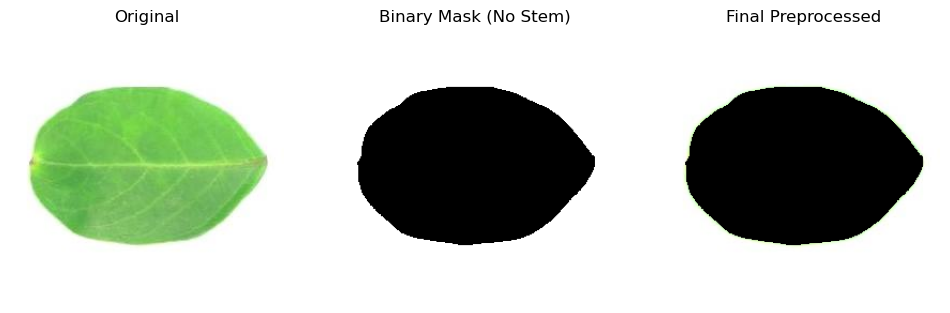

In [5]:
# --- TEST BLOCK ---
# Change this to a real path on your computer!
test_image_path = "./Dataset/train_images/n01440000/n01440000_0002.jpeg" 

if os.path.exists(test_image_path):
    original, mask, final = preprocess_leaf(test_image_path, show_steps=True)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(original); plt.axis('off')
    plt.subplot(1, 3, 2); plt.title("Binary Mask (No Stem)"); plt.imshow(mask, cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 3); plt.title("Final Preprocessed"); plt.imshow(final); plt.axis('off')
    plt.show()
else:
    print(f"Could not find {test_image_path}. Please set a valid path to test.")

# Load Model & Define Feature Extractor

In [8]:
# Load pre-trained AlexNet
base_model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
base_model.to(device)
base_model.eval()

# Define specific extractor for fc6
class TreelogyExtractor(torch.nn.Module):
    def __init__(self, original_model):
        super().__init__()
        self.features = original_model.features
        self.avgpool = original_model.avgpool
        # Isolate classifier 0 (Dropout) and 1 (Linear fc6)
        self.classifier = torch.nn.Sequential(*list(original_model.classifier.children())[:2])

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

extractor = TreelogyExtractor(base_model).to(device)

# Standard transformation for CNN input
cnn_preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Main loop

In [9]:
X = []
y = []
classes = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])

print(f"Found classes: {classes}")

for species in classes:
    species_path = os.path.join(DATA_DIR, species)
    # Collect common image extensions (jpg, jpeg, png)
    images = []
    for ext in ("*.jpg", "*.jpeg", "*.png"):
        images.extend(glob(os.path.join(species_path, ext)))
    
    print(f"Processing {species} ({len(images)} images)...")
    
    for img_path in images:
        try:
            # 1. Preprocess (Get clean leaf)
            clean_leaf_rgb = preprocess_leaf(img_path)
            if clean_leaf_rgb is None: continue
            
            # 2. Prepare for CNN
            img_tensor = cnn_preprocess(clean_leaf_rgb).unsqueeze(0).to(device)
            
            # 3. Extract Features (fc6)
            with torch.no_grad():
                features = extractor(img_tensor)
            
            # Move to CPU and numpy
            X.append(features.cpu().numpy().flatten())
            y.append(species)
            
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

X = np.array(X)
y = np.array(y)
print(f"Done! Feature Matrix Shape: {X.shape}")

Found classes: ['n01440000', 'n01448192', 'n01456384', 'n01464576', 'n01472768', 'n01480960', 'n01489152', 'n01497344', 'n01505536', 'n01513728', 'n01521920', 'n01530112', 'n01538304', 'n01546496', 'n01554688', 'n01562880', 'n01571072', 'n01579264', 'n01587456', 'n01595648', 'n01603840', 'n01612032', 'n01620224', 'n01628416', 'n01636608', 'n01644800', 'n01652992', 'n01661184', 'n01669376', 'n01677568', 'n01685760', 'n01693952', 'n01702144', 'n01710336', 'n01718528', 'n01726720', 'n01734912', 'n01743104', 'n01751296', 'n01759488', 'n01767680', 'n01775872', 'n01784064', 'n01792256', 'n01800448', 'n01808640', 'n01816832', 'n01825024', 'n01833216', 'n01841408', 'n01849600', 'n01857792', 'n01865984', 'n01874176', 'n01882368', 'n01890560', 'n01898752']
Processing n01440000 (200 images)...
Processing n01448192 (692 images)...
Processing n01456384 (452 images)...
Processing n01464576 (448 images)...
Processing n01472768 (760 images)...
Processing n01480960 (472 images)...
Processing n01489152 

# Train

In [ ]:
# Split Data (80% Train, 20% Test) [cite: 213-214]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline: Scale Features -> Linear SVM
# Scaling is MANDATORY for SVM convergence
clf = make_pipeline(StandardScaler(), LinearSVC(dual="auto", max_iter=3000))

print("Training SVM...")
clf.fit(X_train, y_train)

# Validate
preds = clf.predict(X_test)
accuracy = accuracy_score(y_test, preds)

print(f"==========================================")
print(f"Final Treelogy Accuracy: {accuracy * 100:.2f}%")
print(f"==========================================")

Training SVM...
